# Population weighted NDVI

## Packages

In [1]:
import os
import re
import csv
import pandas as pd
import numpy as np
import geopandas as gpd

import rasterio
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize


wd = r'D:\natcap\invest-mental-health\data'
os.chdir(wd)
os.getcwd()

# Get the parent folder path
parent_folder = os.path.dirname(os.getcwd())

# Define the output directory inside the parent folder
figures_dir = os.path.join(parent_folder, "figures")


In [2]:
import sys
import platform

# Print Python version
print("Python Version:")
print(sys.version)
print()


# Print the current platform information
print("Platform:")
print(platform.platform())
print()

Python Version:
3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]

Platform:
Windows-10-10.0.22631-SP0



## Functions

In [3]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:
    #   for more colormap, see https://matplotlib.org/stable/users/explain/colors/colormaps.html

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N, 0))
    cmap_name = base.name + str(N)
    return plt.cm.colors.ListedColormap(color_list, color_list, N)




# Function to plot raster with a legend
def plot_raster_with_legend(raster_path):
    # Open the demand raster
    with rasterio.open(raster_path) as src:
        data = src.read(1)  # Read the first band
        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
        # Get unique values
        unique_values = np.unique(data); print(unique_values)
        # Generate colors for each unique value
        N = len(unique_values)
        min_val = min(unique_values)
        max_val = max(unique_values)

    
    # Plot the raster
    fig, ax = plt.subplots(figsize=(10, 6))
    raster_show = plt.imshow(data, extent=extent,
              cmap=discrete_cmap(N, 'Set2'))  # adjust cmap as needed
    # Overlay the vector (shapefile)
    gdf.plot(ax=ax, facecolor='none', edgecolor='red')  # adjust colors as needed
    fig.colorbar(raster_show, ax=ax, ticks=unique_values, fraction=0.036, pad=0.04)
    plt.clim(min_val-abs(min_val)*0.4, max_val+0.1) # set the color limits.
    ax.axis('off')  # Remove axis ticks and labels
    plt.show()



## Run the function 
# plot_raster_with_legend(files[0])




def reproject_raster_to_match(src_path, target_path, dst_path, resampling_method=Resampling.nearest):
    """
    Reprojects the raster at src_path to match the projection and grid of the raster at target_path.
    The reprojected raster is saved to dst_path.
    
    Parameters:
      src_path (str): Path to the source raster.
      target_path (str): Path to the target raster (whose CRS and grid we want to match).
      dst_path (str): Path where the reprojected raster will be saved.
      resampling_method: A rasterio.warp.Resampling method. Default is Resampling.nearest.
                         For continuous data (e.g., NDVI), consider Resampling.bilinear.
    
    Returns:
      None
    """
    # Open the target raster to get its CRS, transform, width, and height.
    with rasterio.open(target_path) as target_src:
        target_crs = target_src.crs
        target_transform = target_src.transform
        target_width = target_src.width
        target_height = target_src.height

    # Open the source raster and reproject it to match the target's grid.
    with rasterio.open(src_path) as src:
        # Create a new metadata dictionary for the output raster
        dst_meta = src.meta.copy()
        dst_meta.update({
            'crs': target_crs,
            'transform': target_transform,
            'width': target_width,
            'height': target_height
        })

        # Prepare an empty destination array for all bands.
        destination = np.empty((src.count, target_height, target_width), dtype=src.meta['dtype'])

        # Reproject each band.
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=destination[i-1],
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=target_transform,
                dst_crs=target_crs,
                resampling=resampling_method
            )

    # Write the reprojected data to the destination file.
    with rasterio.open(dst_path, 'w', **dst_meta) as dst:
        dst.write(destination)
    print(f"Reprojected raster saved to: {dst_path}")

# Example usage:
# reproject_raster_to_match("path/to/source_raster.tif", "path/to/target_raster.tif", "path/to/destination_raster.tif")


## Function - projection

In [4]:

# Define target CRS (for example, using EPSG code)
target_crs = "EPSG:5070"  # or another CRS like "EPSG:5070" for NAD83/Conus Albers

import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling


## Function to Reproject a Raster
def reproject_raster(src_path, target_crs, dst_path, resampling_method=Resampling.nearest):
    """
    Reproject a raster to a target CRS if needed.
    
    Parameters:
      src_path (str): Path to the source raster.
      target_crs (dict or CRS): The target coordinate reference system (CRS). 
                                This can be provided as a dict (e.g., from rasterio.crs.CRS) or an EPSG string.
      dst_path (str): Path where the reprojected raster will be saved.
      resampling_method: Resampling method to use (default is Resampling.nearest).
                         For continuous data, consider Resampling.bilinear.
    
    Returns:
      None. The reprojected raster is written to dst_path.
    """
    with rasterio.open(src_path) as src:
        src_crs = src.crs
        # Check if the source CRS matches the target CRS
        if src_crs == target_crs:
            print("Raster CRS already matches the target CRS. Copying file to destination.")
            # Optionally, copy the file without reprojecting
            with rasterio.open(dst_path, 'w', **src.meta) as dst:
                dst.write(src.read())
            return
        
        # Compute the transform, width, and height of the reprojected raster.
        transform, width, height = calculate_default_transform(
            src.crs, target_crs, src.width, src.height, *src.bounds)
        
        # Update the metadata for the output raster.
        dst_meta = src.meta.copy()
        dst_meta.update({
            'crs': target_crs,
            'transform': transform,
            'width': width,
            'height': height
        })
        
        # Create an empty destination array for all bands.
        destination = None
        with rasterio.open(dst_path, 'w', **dst_meta) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=target_crs,
                    resampling=resampling_method
                )
    print(f"Reprojected raster saved to: {dst_path}")





## Function to Reproject a Shapefile
import geopandas as gpd

def reproject_shapefile(shp_path, target_crs, dst_path=None):
    """
    Reproject a shapefile to a target CRS if needed.
    
    Parameters:
      shp_path (str): File path to the input shapefile.
      target_crs (dict or str): The target CRS. Can be an EPSG string (e.g., "EPSG:4326") or a CRS object.
      dst_path (str, optional): If provided, the reprojected shapefile is saved to this path.
    
    Returns:
      geopandas.GeoDataFrame: The reprojected GeoDataFrame.
    """
    # Read the shapefile
    gdf = gpd.read_file(shp_path)
    
    # Check if the shapefile's CRS matches the target CRS
    if gdf.crs != target_crs:
        print(f"Reprojecting shapefile from {gdf.crs} to {target_crs}")
        gdf = gdf.to_crs(target_crs)
    else:
        print("Shapefile CRS already matches the target CRS.")
    
    # If an output path is provided, save the reprojected GeoDataFrame.
    if dst_path:
        gdf.to_file(dst_path)
        print(f"Reprojected shapefile saved to: {dst_path}")
    
    return gdf

# Example usage for the shapefile function:
# target_crs can be specified as an EPSG code string, e.g., "EPSG:4326"
# reprojected_gdf = reproject_shapefile("path/to/input_shapefile.shp", "EPSG:4326", "path/to/output_shapefile.shp")




## Function - clip raster

In [5]:
import os
import geopandas as gpd
import rasterio
from rasterio.mask import mask

def clip_raster(raster_path, clipping_geom, output_path=None, nodata_value=None):
    """
    Clips a raster to the provided geometry.
    
    Parameters:
      raster_path (str): Path to the input raster.
      clipping_geom (shapely.geometry or list): A single geometry or list of geometries (GeoJSON-like) 
                                                 used for clipping.
      output_path (str, optional): If provided, the clipped raster is saved to this path.
      nodata_value (optional): If provided, used as the nodata value for clipping.
    
    Returns:
      out_image (numpy.ndarray): The clipped raster array (all bands).
      out_meta (dict): The updated metadata for the clipped raster.
    """
    with rasterio.open(raster_path) as src:
        out_nodata = nodata_value if nodata_value is not None else src.nodata
        out_image, out_transform = mask(src, clipping_geom, crop=True, nodata=out_nodata)
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform,
            "nodata": out_nodata
        })
    
    if output_path:
        out_dir = os.path.dirname(output_path)
        if out_dir:
            os.makedirs(out_dir, exist_ok=True)
        with rasterio.open(output_path, "w", **out_meta) as dst:
            dst.write(out_image)
        print(f"Clipped raster saved to: {output_path}")
    
    return out_image, out_meta


## Input data

### Shapefiles

Reprojecting shapefile from EPSG:4269 to EPSG:5070
6
6
     STATEFP COUNTYFP TRACTCE              AFFGEOID        GEOID     NAME  \
7020      06      081  600100  1400000US06081600100  06081600100     6001   
2751      06      081  600200  1400000US06081600200  06081600200     6002   
4070      06      081  600300  1400000US06081600300  06081600300     6003   
427       06      081  600402  1400000US06081600402  06081600402  6004.02   
7703      06      081  600700  1400000US06081600700  06081600700     6007   
3809      06      081  600900  1400000US06081600900  06081600900     6009   

     LSAD     ALAND   AWATER  \
7020   CT  14678364  2117778   
2751   CT   1158755        0   
4070   CT   2183130        0   
427    CT    402368        0   
7703   CT    804173        0   
3809   CT   2039502   306981   

                                               geometry  
7020  POLYGON ((-2275921.377 1948316.900, -2275439.1...  
2751  GEOMETRYCOLLECTION (POINT (-2276394.818 194845...  
4070  

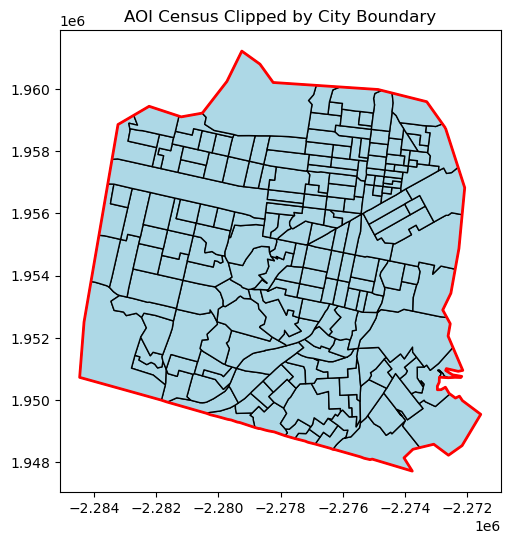

In [6]:
# Load the shapefile

## 1. boundary 
aoi_adm1_path = 'cb_2019_us_county_500k_06075_clip.shp'
# aoi_adm1 = gpd.read_file(aoi_adm1_path)
aoi_adm1 = reproject_shapefile(aoi_adm1_path, target_crs, dst_path=None)
aoi_adm1_geometry = [aoi_adm1.geometry.unary_union]


## 2. tract shp
aoi_adm2_path = "D:/data/shp/US_census_Cartographic_Boundary_Shapefiles/cb_2019_06_tract_500k/cb_2019_06_tract_500k.shp"    # AOI shapefile at census tract level
aoi_adm2_clipped_path = "aoi_adm2_clipped.shp"
aoi_adm2 = gpd.read_file(aoi_adm2_path)

## bg shp
aoi_adm3_path = 'D:/data/shp/US_census_Cartographic_Boundary_Shapefiles/cb_2019_06_bg_500k/cb_2019_06_bg_500k.shp'
aoi_adm3_clipped_path = "aoi_adm3_clipped.shp"
aoi_adm3 = gpd.read_file(aoi_adm3_path)

## 3. clip adm2 with adm1
# Ensure both GeoDataFrames are in the same CRS; if not, reproject aoi_adm2_clipped_clipped_clipped_clipped_clipped_clipped_clipped_clipped_clipped_clipped to match aoi_adm1
if aoi_adm2.crs != aoi_adm1.crs:
    aoi_adm2 = aoi_adm2.to_crs(aoi_adm1.crs)

# Clip aoi_adm2 by the city boundary using geopandas.clip()
# (This will clip each geometry in aoi_adm2 to the overlapping area with aoi_adm1.
# If aoi_adm1 contains multiple polygons, GeoPandas will use their union.)
aoi_adm2_clipped = gpd.clip(aoi_adm2, aoi_adm1)

# Define a minimum area threshold (in square meters)
min_area = 100  # Adjust this threshold as needed


# Print or inspect the filtered GeoDataFrame
aoi_adm2_clipped_small = aoi_adm2_clipped[aoi_adm2_clipped.area < min_area]
print(len(aoi_adm2_clipped_small))
print(aoi_adm2_clipped_small.shape[0])
print(aoi_adm2_clipped_small)

# Filter out very small polygons
aoi_adm2_clipped = aoi_adm2_clipped[aoi_adm2_clipped.area > min_area]


# Optionally, save the clipped GeoDataFrame to a new shapefile
aoi_adm2_clipped.to_file(aoi_adm2_clipped_path)
print(f"\n\nClipped AOI census saved to: {aoi_adm2_clipped_path}")

# Plot the result
fig, ax = plt.subplots(figsize=(10, 6))
aoi_adm2_clipped.plot(ax=ax, edgecolor="black", facecolor="lightblue")
aoi_adm1.boundary.plot(ax=ax, edgecolor="red", linewidth=2)
ax.set_title("AOI Census Clipped by City Boundary")
plt.show()


#### adm3

10
10


Clipped AOI census saved to: aoi_adm3_clipped.shp


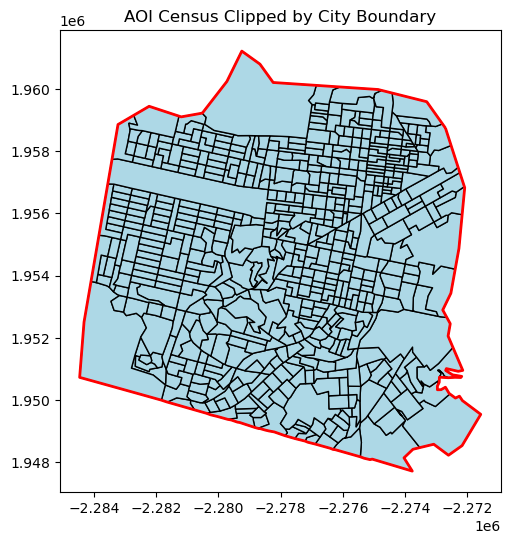

In [7]:
## bg shp
aoi_adm3_path = 'D:/data/shp/US_census_Cartographic_Boundary_Shapefiles/cb_2019_06_bg_500k/cb_2019_06_bg_500k.shp'
aoi_adm3_clipped_path = "aoi_adm3_clipped.shp"
aoi_adm3 = gpd.read_file(aoi_adm3_path)

## 3. clip adm2 with adm1
# Ensure both GeoDataFrames are in the same CRS; if not, reproject aoi_adm3_clipped_clipped_clipped_clipped_clipped_clipped_clipped_clipped_clipped_clipped to match aoi_adm1
if aoi_adm3.crs != aoi_adm1.crs:
    aoi_adm3 = aoi_adm3.to_crs(aoi_adm1.crs)

# Clip aoi_adm3 by the city boundary using geopandas.clip()
# (This will clip each geometry in aoi_adm3 to the overlapping area with aoi_adm1.
# If aoi_adm1 contains multiple polygons, GeoPandas will use their union.)
aoi_adm3_clipped = gpd.clip(aoi_adm3, aoi_adm1)

# Define a minimum area threshold (in square meters)
min_area = 100  # Adjust this threshold as needed


# Print or inspect the filtered GeoDataFrame
aoi_adm3_clipped_small = aoi_adm3_clipped[aoi_adm3_clipped.area < min_area]
print(len(aoi_adm3_clipped_small))
print(aoi_adm3_clipped_small.shape[0])

# Filter out very small polygons
aoi_adm3_clipped = aoi_adm3_clipped[aoi_adm3_clipped.area > min_area]


# Optionally, save the clipped GeoDataFrame to a new shapefile
aoi_adm3_clipped.to_file(aoi_adm3_clipped_path)
print(f"\n\nClipped AOI census saved to: {aoi_adm3_clipped_path}")

# Plot the result
fig, ax = plt.subplots(figsize=(10, 6))
aoi_adm3_clipped.plot(ax=ax, edgecolor="black", facecolor="lightblue")
aoi_adm1.boundary.plot(ax=ax, edgecolor="red", linewidth=2)
ax.set_title("AOI Census Clipped by City Boundary")
plt.show()

#### adm_i selected for analysis

In [8]:
# adm_i = 

### Population

Reprojected raster saved to: usa_ppp_2020_UNadj_constrained_SF_prj.tif
Clipped raster saved to: usa_ppp_2020_UNadj_constrained_SF_prj_clipped.tif
0.0
1000.08453


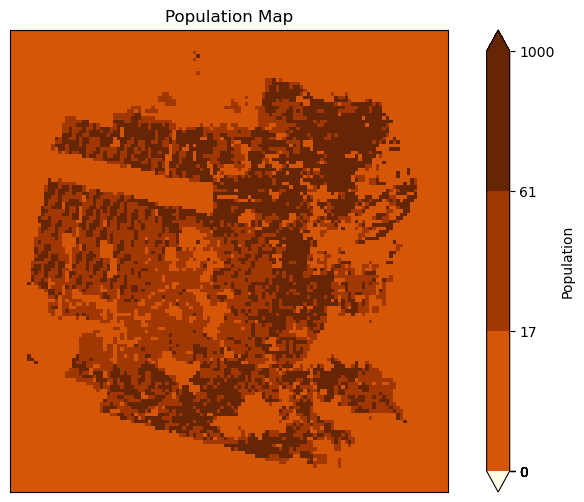

In [9]:
import rasterio
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.colors as colors

# Path to the population raster
population_raster_path = 'usa_ppp_2020_UNadj_constrained_SF_proj_setnull.tif'
pop_dst_path = 'usa_ppp_2020_UNadj_constrained_SF_prj.tif'
pop_dst_dir  = 'usa_ppp_2020_UNadj_constrained_SF_prj_clipped.tif'
reproject_raster(population_raster_path, target_crs, pop_dst_path, resampling_method=Resampling.nearest)
## Clip the raster
# Use the union of AOI geometries for clipping
aoi_adm1_geom = [aoi_adm1.geometry.unary_union.__geo_interface__]
# aoi_adm1_geom = [aoi_adm2_clipped.geometry.unary_union.__geo_interface__]
clipped_image, clipped_meta = clip_raster(pop_dst_path, aoi_adm1_geom, pop_dst_dir)


# Read the population raster
with rasterio.open(pop_dst_dir) as src:
    population_data = src.read(1)
    population_meta = src.meta

    ## Set pixels with values less than 0 to NaN
    # population_data = np.where(population_data < 0, np.nan, population_data) ## to NA
    population_data = np.where(population_data < 0, 0, population_data)      ## to 0
    # Update the metadata to reflect the new no-data value
    population_meta.update(dtype=rasterio.float32, nodata=np.nan)

    transform = src.transform
    crs = src.crs  # Coordinate reference system
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    # Calculate the min and max values of the population data
    pop_min = np.min(population_data[np.isfinite(population_data)])  # Ignore NaN or inf values
    pop_max = np.max(population_data[np.isfinite(population_data)])  # Ignore NaN or inf values
    # Calculate quantiles (e.g., 5 quantiles for simplicity)
    quantiles = np.nanquantile(population_data, [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0])

print(pop_min)
print(pop_max)

# Plot the population data
plt.figure(figsize=(10, 6))
norm_pop = colors.BoundaryNorm(boundaries=quantiles, ncolors=256)
plt.imshow(population_data, cmap='YlOrBr', extent=extent, norm=norm_pop)  # Use a colormap suitable for NDVI
plt.colorbar(label='Population', extend = 'both')
plt.title('Population Map')
# Remove axis ticks and labels in a single step
plt.xticks([])
plt.yticks([])
# Show the plot
plt.show()




### Resample

In [10]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np

def resample_raster_to_target(src_path, target_meta, resampling_method=Resampling.nearest):
    """
    Resample the raster from src_path to match the target_meta's resolution, transform, and dimensions.
    
    Parameters:
      src_path (str): Path to the source raster.
      target_meta (dict): A metadata dictionary (from another raster) with desired 'transform', 'width', and 'height'.
      resampling_method: Resampling method to use (default: Resampling.nearest; use Resampling.bilinear for continuous data).
    
    Returns:
      numpy.ndarray: The resampled raster data (all bands).
    """
    with rasterio.open(src_path) as src:
        # Read all bands
        src_data = src.read()
        # Create an empty array with target dimensions
        dest_data = np.empty((src.count, target_meta["height"], target_meta["width"]), dtype=src.meta['dtype'])
        
        reproject(
            source=src_data,
            destination=dest_data,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=target_meta["transform"],
            dst_crs=target_meta["crs"],
            resampling=resampling_method
        )
    return dest_data

# Example usage:
# Assume we have two rasters:
# 1. A NDVI raster at 10 m resolution.
# 2. A population raster at 100 m resolution.
#
# Our goal is to perform calculations (e.g., population-weighted NDVI) at the 100 m resolution.
# Therefore, we will resample the NDVI raster to match the population raster's grid.



### Load NDVI

In [11]:
# Read NDVI image
ndvi_path     = 'ndvi_s2_075_2019_10m_v2.tif'
ndvi_dst_path = 'ndvi_s2_075_2019_10m_v2_prj.tif'
ndvi_dst_dir  = 'ndvi_s2_075_2019_10m_v2_prj_clipped.tif'
ndvi_dst_dir_resampled = "ndvi_s2_075_2019_10m_v2_prj_clipped_100m.tif"


## check projection and reproject if needed 
reproject_raster(ndvi_path, target_crs, ndvi_dst_path, resampling_method=Resampling.nearest)

## Clip the raster
clip_raster(ndvi_dst_path, aoi_adm1_geom, ndvi_dst_dir)


# Open the population raster to get target grid info
with rasterio.open(pop_dst_dir) as pop_src:
    pop_meta = pop_src.meta.copy()
    # We assume the population raster is our target resolution
    target_meta = {
        "crs": pop_meta["crs"],
        "transform": pop_meta["transform"],
        "width": pop_meta["width"],
        "height": pop_meta["height"]
    }

# Resample the NDVI raster to the population raster's grid
ndvi_resampled = resample_raster_to_target(ndvi_dst_dir, target_meta, resampling_method=Resampling.bilinear)

# (Optional) Save the resampled NDVI raster
pop_meta.update({"dtype": ndvi_resampled.dtype, "count": ndvi_resampled.shape[0]})
with rasterio.open(ndvi_dst_dir_resampled, 'w', **pop_meta) as dst:
    dst.write(ndvi_resampled)
print(f"Resampled NDVI saved to: {ndvi_dst_dir_resampled}")



Reprojected raster saved to: ndvi_s2_075_2019_10m_v2_prj.tif
Clipped raster saved to: ndvi_s2_075_2019_10m_v2_prj_clipped.tif
Resampled NDVI saved to: ndvi_s2_075_2019_10m_v2_prj_clipped_100m.tif


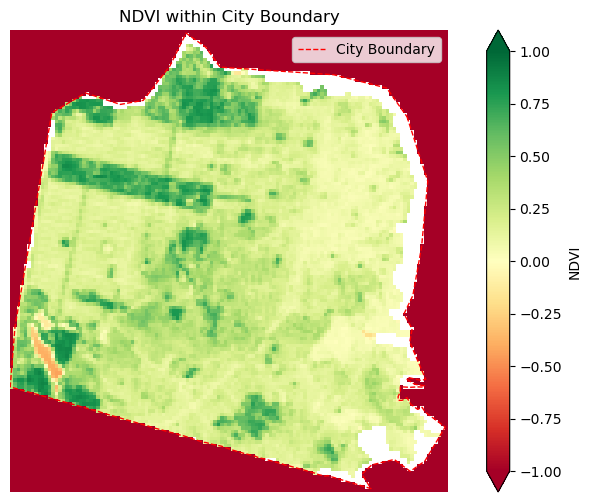

In [12]:


with rasterio.open(ndvi_dst_dir_resampled) as src:
    ndvi_clipped, ndvi_clipped_transform = mask(src, aoi_adm1_geom, crop=True)
    ndvi_clipped_meta = src.meta.copy()
    ndvi_clipped_meta.update({
        "driver": "GTiff",
        "height": ndvi_clipped.shape[1],
        "width": ndvi_clipped.shape[2],
        "transform": ndvi_clipped_transform
    })


# Step 6: Visualize the clipped NDVI with AOI and city boundary overlay
fig, ax = plt.subplots(figsize=(10, 6))
norm = Normalize(vmin=-1, vmax=1)
plt.imshow(ndvi_clipped[0], 
           cmap='RdYlGn', 
           norm=norm,
           extent=[
    ndvi_clipped_transform[2],  # x_min
    ndvi_clipped_transform[2] + ndvi_clipped_transform[0] * ndvi_clipped.shape[2],  # x_max
    ndvi_clipped_transform[5] + ndvi_clipped_transform[4] * ndvi_clipped.shape[1],  # y_min
    ndvi_clipped_transform[5]  # y_max
])
plt.colorbar(label='NDVI', extend='both')
aoi_adm1.boundary.plot(ax=ax, edgecolor='red', linewidth=1, linestyle='--', label='City Boundary')

# Customize the plot
ax.set_title('NDVI within City Boundary')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.axis('off')
plt.legend()
# plt.savefig(OUTPUT_NDVI, bbox_inches='tight', dpi=300)
plt.show()

# PWE

## Function - PWE

In [13]:
import numpy as np
import rasterio
from rasterio.mask import mask
from rasterio.warp import reproject, Resampling
from shapely.geometry.base import BaseGeometry
from shapely.geometry import box
import geopandas as gpd
import os

def clip_raster(raster_path, clipping_geom, output_path=None, nodata_value=None):
    """
    Clips a raster to the provided geometry.
    
    Parameters:
      raster_path (str): Path to the input raster.
      clipping_geom (shapely.geometry or list): A single geometry or list of geometries (GeoJSON-like) 
                                                 used for clipping.
      output_path (str, optional): If provided, the clipped raster is saved to this path.
      nodata_value (optional): If provided, used as the nodata value for clipping.
    
    Returns:
      out_image (numpy.ndarray): The clipped raster array (all bands).
      out_meta (dict): The updated metadata for the clipped raster.
    """
    with rasterio.open(raster_path) as src:
        out_nodata = nodata_value if nodata_value is not None else src.nodata
        # Use rasterio.mask.mask to clip
        out_image, out_transform = mask(src, clipping_geom, crop=True, nodata=out_nodata)

        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform,
            "nodata": out_nodata
        })
    
    if output_path:
        out_dir = os.path.dirname(output_path)
        if out_dir:
            os.makedirs(out_dir, exist_ok=True)
        with rasterio.open(output_path, "w", **out_meta) as dst:
            dst.write(out_image)
        print(f"Clipped raster saved to: {output_path}")
    
    return out_image, out_meta


def calculate_weighted_ndvi(
    polygon,            # Shapely geometry or GeoDataFrame/GeoSeries
    ndvi_path,
    pop_path,
    save_ndvi_clip_path=None,
    save_polygon_path=None
):
    """
    Clips both the NDVI and population rasters to the given polygon and calculates 
    the population-weighted NDVI = sum(NDVI_i * POP_i) / sum(POP_i).
    
    All geometry/polygon, NDVI, and population data must be in the same CRS or 
    reprojected accordingly. If they do not overlap, this function returns np.nan.
    """

    # ---------------------
    # 1. Open rasters to get metadata
    # ---------------------
    with rasterio.open(ndvi_path) as ndvi_src:
        ndvi_crs = ndvi_src.crs
        ndvi_bounds = ndvi_src.bounds
        ndvi_nodata = ndvi_src.nodata
        ndvi_meta = ndvi_src.meta.copy()

    with rasterio.open(pop_path) as pop_src:
        pop_crs = pop_src.crs
        pop_nodata = pop_src.nodata
        pop_transform = pop_src.transform

    # ---------------------
    # 2. Convert polygon to same CRS as NDVI raster
    # ---------------------
    if isinstance(polygon, (gpd.GeoDataFrame, gpd.GeoSeries)):
        poly_crs = polygon.crs
        polygon = polygon.iloc[0]  # Use first geometry
    else:
        poly_crs = None

    if poly_crs is not None and poly_crs != ndvi_crs:
        poly_gdf = gpd.GeoDataFrame({'geometry': [polygon]}, crs=poly_crs)
        poly_gdf = poly_gdf.to_crs(ndvi_crs)
        polygon = poly_gdf.geometry.iloc[0]

    if not isinstance(polygon, BaseGeometry):
        raise ValueError("The 'polygon' is not a valid Shapely geometry.")

    # ---------------------
    # 3. Optional: Save polygon
    # ---------------------
    if save_polygon_path:
        out_dir = os.path.dirname(save_polygon_path)
        if out_dir:
            os.makedirs(out_dir, exist_ok=True)
        poly_gdf = gpd.GeoDataFrame({'geometry': [polygon]}, crs=ndvi_crs)
        poly_gdf.to_file(save_polygon_path)
        print(f"[INFO] Polygon saved to: {save_polygon_path}")

    # ---------------------
    # 4. Check overlap
    # ---------------------
    raster_box = box(*ndvi_bounds)
    if not polygon.intersects(raster_box):
        print("[WARNING] Polygon does not overlap NDVI raster.")
        return np.nan

    # ---------------------
    # 5. Clip NDVI using clip_raster function
    # ---------------------
    ndvi_clip_data, ndvi_clip_meta = clip_raster(
        raster_path=ndvi_path,
        clipping_geom=[polygon.__geo_interface__],
        output_path=save_ndvi_clip_path,
        nodata_value=ndvi_nodata
    )

    # We'll use only the first band
    ndvi_clip = ndvi_clip_data[0].astype(np.float32)
    if ndvi_nodata is not None:
        ndvi_clip[ndvi_clip == ndvi_nodata] = np.nan

    # ---------------------
    # 6. Clip Population using clip_raster
    # ---------------------
    # Not saving population clip by default, but you could add an optional arg if desired.
    pop_clip_data, pop_clip_meta = clip_raster(
        raster_path=pop_path,
        clipping_geom=[polygon.__geo_interface__],
        output_path=None,  # or provide a path if you want to save
        nodata_value=pop_nodata
    )

    pop_clip = pop_clip_data[0].astype(np.float32)
    if pop_nodata is not None:
        pop_clip[pop_clip == pop_nodata] = np.nan

    # ---------------------
    # 7. Check NDVI vs. Population CRS
    # ---------------------
    if ndvi_crs != pop_crs:
        raise ValueError(
            f"NDVI raster CRS ({ndvi_crs}) != population raster CRS ({pop_crs}). "
            "Reproject one of them before clipping."
        )

    # ---------------------
    # 8. Resample NDVI if shapes differ
    # ---------------------
    ndvi_transform = ndvi_clip_meta["transform"]
    pop_transform_ = pop_clip_meta["transform"]  # rename to avoid confusion

    if ndvi_clip.shape != pop_clip.shape:
        print("[INFO] Resampling NDVI to match population grid.")
        dest_ndvi = np.empty_like(pop_clip, dtype=np.float32)
        reproject(
            source=ndvi_clip,
            destination=dest_ndvi,
            src_transform=ndvi_transform,
            src_crs=ndvi_crs,
            dst_transform=pop_transform_,
            dst_crs=pop_crs,
            resampling=Resampling.bilinear
        )
        ndvi_clip = dest_ndvi
        ndvi_clip_meta.update({
            "transform": pop_transform_,
            "width": pop_clip.shape[2] if len(pop_clip.shape) == 3 else pop_clip.shape[1],
            "height": pop_clip.shape[1] if len(pop_clip.shape) == 3 else pop_clip.shape[0]
        })

    # ---------------------
    # 9. Compute population-weighted NDVI
    # ---------------------
    valid_mask = ~np.isnan(ndvi_clip) & ~np.isnan(pop_clip)
    total_pop = np.nansum(pop_clip[valid_mask])
    weighted_sum = np.nansum(ndvi_clip[valid_mask] * pop_clip[valid_mask])

    ## for data checking  
    # print('ndvi_clip  array: ', ndvi_clip[valid_mask])
    # print('ndvi_clip length: ', len(ndvi_clip[valid_mask]), '\n')

    if total_pop > 0:
        return weighted_sum / total_pop
    else:
        return np.nan


## Load data

In [14]:

# --------------------------
# Main workflow
# --------------------------

# File paths (update these to match your data)
# File paths (update these as needed)
ndvi_raster_path = ndvi_dst_dir          # NDVI raster (e.g., in meters, in a projection like Albers)
pop_raster_path = pop_dst_dir            # Population raster (same resolution & projection as NDVI ideally)

aoi_admi_path = aoi_adm2_clipped_path
aoi_admi_clipped = aoi_adm2_clipped; adm_level = '2'

# aoi_admi_path = aoi_adm3_clipped_path
# aoi_admi_clipped = aoi_adm3_clipped; adm_level = '3'

print(ndvi_dst_dir)


ndvi_s2_075_2019_10m_v2_prj_clipped.tif


## Plot rasters

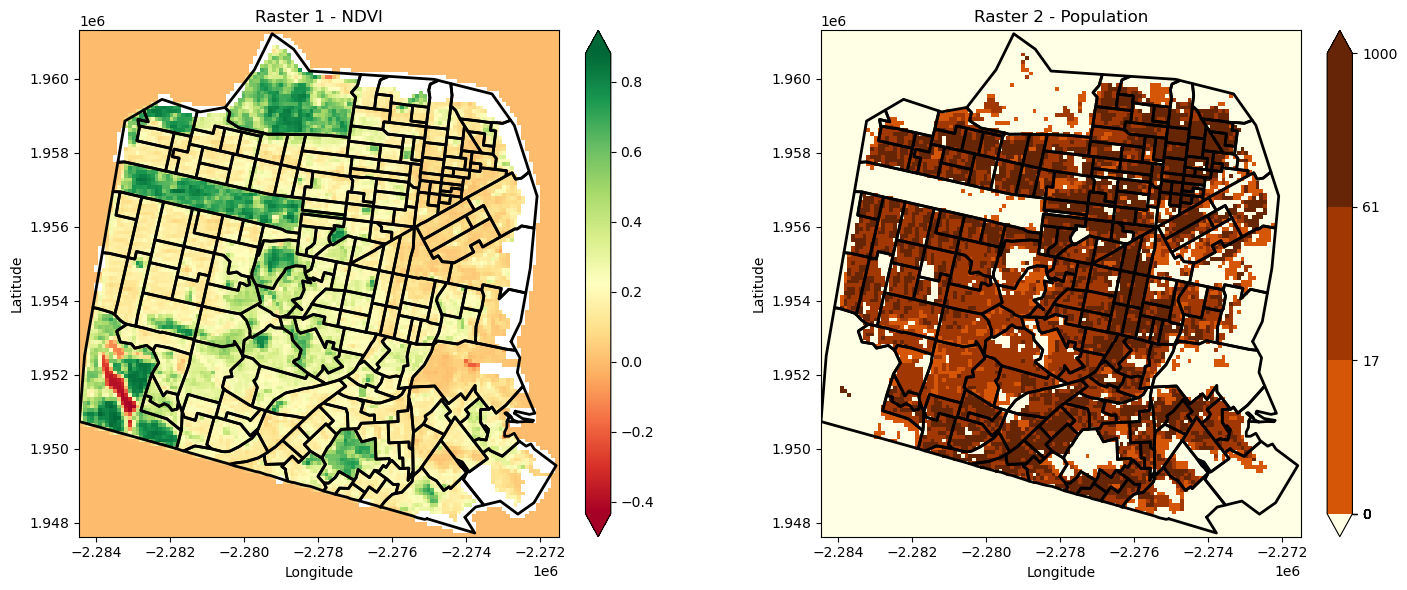

In [15]:
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show

def get_extent(src):
    """
    Given a rasterio dataset src, return its extent as:
    [x_min, x_max, y_min, y_max]
    """
    transform = src.transform
    width = src.width
    height = src.height
    # For a typical affine transform, the upper-left corner is (c, f)
    # and pixel width = a, pixel height = e (often negative).
    x_min = transform[2]
    x_max = x_min + transform[0] * width
    # When the pixel height is negative, the upper-left y is the max.
    y_max = transform[5]
    y_min = y_max + transform[4] * height
    return [x_min, x_max, y_min, y_max]

# File paths for the two rasters (update these paths as needed) -------------------------------
raster1_path = ndvi_dst_dir_resampled
raster2_path = pop_dst_dir

# Open the first raster and read data
with rasterio.open(raster1_path) as src1:
    raster1_data = src1.read(1)  # read first band
    extent1 = get_extent(src1)
    crs1 = src1.crs

# Open the second raster and read data
with rasterio.open(raster2_path) as src2:
    raster2_data = src2.read(1)
    extent2 = get_extent(src2)
    crs2 = src2.crs


# Reproject AOI to match raster1 CRS (for the left plot)
if aoi_admi_clipped.crs != crs1:
    aoi_proj1 = aoi_admi_clipped.to_crs(crs1)
else:
    aoi_proj1 = aoi_admi_clipped.copy()

# Reproject AOI to match raster2 CRS (for the right plot)
if aoi_admi_clipped.crs != crs2:
    aoi_proj2 = aoi_admi_clipped.to_crs(crs2)
else:
    aoi_proj2 = aoi_admi_clipped.copy()


# Create subplots to display the two rasters side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot the first raster
im1 = ax1.imshow(raster1_data, cmap='RdYlGn', extent=extent1)
aoi_proj1.boundary.plot(ax=ax1, edgecolor='black', linewidth=2, label='AOI')
ax1.set_title('Raster 1 - NDVI')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04, extend='both')

# Plot the second raster
im2 = ax2.imshow(raster2_data, cmap='YlOrBr', extent=extent2, norm=norm_pop)
aoi_proj2.boundary.plot(ax=ax2, edgecolor='black', linewidth=2, label='AOI')
ax2.set_title('Raster 2 - Population')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04, extend='both')

plt.tight_layout()

# Save the figure as a PNG file
output_plot_path = os.path.join(figures_dir, "NDVI_Population.png")
plt.savefig(output_plot_path, dpi=300, bbox_inches="tight", transparent=True)

plt.show()




## Run data

In [16]:
# Calculate population weighted NDVI 


## 1. for the whole region 
# polyg = aoi_adm1.geometry 
# w_ndvi_w = calculate_weighted_ndvi(polyg, ndvi_dst_dir, pop_dst_dir)



## 2. for each census tract
weighted_ndvi_list = []
for idx, row in aoi_admi_clipped.iterrows():
## for testing 
# for idx, row in aoi_admi_clipped.head(2).iterrows():
    poly = row.geometry
    # print(poly)
    w_ndvi = calculate_weighted_ndvi(poly, ndvi_dst_dir_resampled, pop_raster_path, 
                                     None, None)
                                    #  'outputs_pwe/ndvi_' + str(idx) + '.tif',
                                    #  'outputs_pwe/poly_' + str(idx) + '.shp')
    weighted_ndvi_list.append(w_ndvi)
    # ## used to check errors
    # print(idx)
    # print(row.head())
    # print('\nDone .........\n\n')


## Save as CSV

In [17]:

# Add the computed values as a new column
aoi_admi_clipped["weighted_ndvi"] = weighted_ndvi_list

# # Save the results as a CSV file (dropping geometry if desired)
output_ndvi_csv = "population_weighted_ndvi_by_adm" + adm_level + ".csv"

aoi_admi_clipped.drop(columns="geometry").to_csv(output_ndvi_csv, index=False, na_rep="NA")
print("CSV file saved to:", output_ndvi_csv)

# print(aoi_admi_clipped.head())


## result summary 
print("\nSummary Statistics:")
print(aoi_admi_clipped["weighted_ndvi"].describe())


CSV file saved to: population_weighted_ndvi_by_adm2.csv

Summary Statistics:
count    194.000000
mean       0.187460
std        0.079650
min        0.048984
25%        0.142650
50%        0.177417
75%        0.221351
max        0.490744
Name: weighted_ndvi, dtype: float64


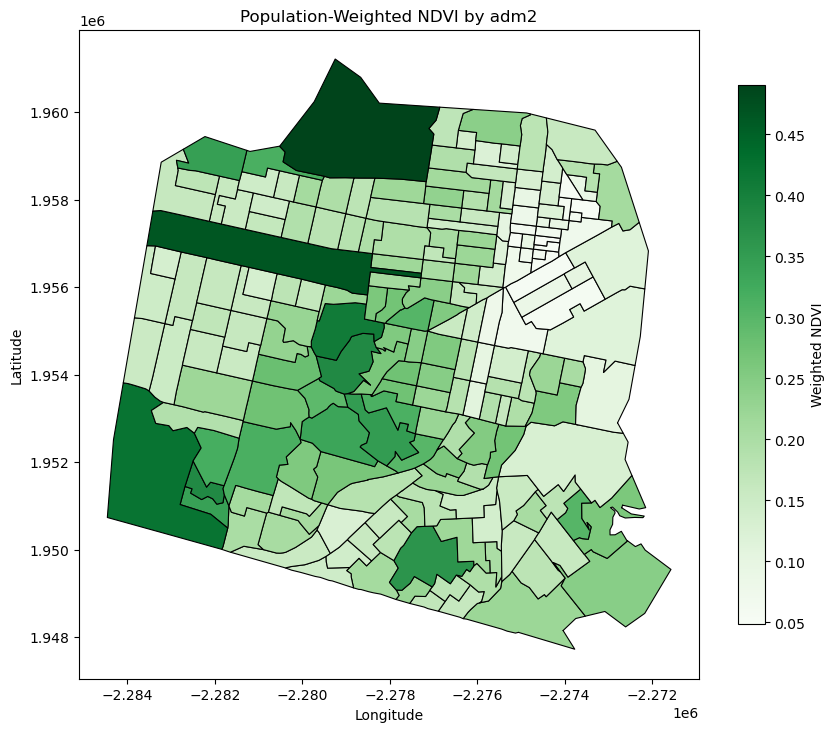

In [18]:

# Plot the census tracts color-coded by population-weighted NDVI
fig, ax = plt.subplots(figsize=(10, 10))
aoi_admi_clipped.plot(column="weighted_ndvi", cmap="Greens", 
                      linewidth=0.8, ax=ax, edgecolor="black", 
                      legend_kwds={
                          "shrink": 0.7,             # Shrink the colorbar
                          "label": "Weighted NDVI",  # Add a legend label
                          "orientation": "vertical"  # 'horizontal' also possible
                        },
                      legend=True)
ax.set_title("Population-Weighted NDVI by adm" + adm_level)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

# Tree cover

## load data and preprocess

In [19]:
import geopandas as gpd
import pandas as pd
from rasterstats import zonal_stats

# ---------------------------
# Configuration / File paths
# ---------------------------
esa_worldcover_path = "lulc/ESA_WORLDCOVER_10M_2021_V200/ESA_WorldCover_10m_2021_v200_N36W123_Map.tif"  # ESA WorldCover raster

# ---------------------------
# Step 1: (skip if have already done)
# ---------------------------

# # reproject census to the raster's CRS if needed
raster_reproject_path = esa_worldcover_path.replace(".tif", "_prj.tif") 
raster_clipped_path = raster_reproject_path.replace(".tif", "_clipped.tif") 
# reproject_raster(esa_worldcover_path, target_crs, raster_reproject_path, resampling_method=Resampling.nearest)
# ## Clip the raster
# clipped_image, clipped_meta = clip_raster(raster_reproject_path, aoi_adm1_geom, raster_clipped_path)


# census_shapefile = aoi_adm2_clipped_path # aoi_admi_path   # Replace with your census tract shapefile
# census = gpd.read_file(census_shapefile)
# print(aoi_admi_clipped.info())
# print(census.info())


## it seems the Index is different in the two data files
aoi_admi_clipped.reset_index(drop=True, inplace=True)
print(aoi_admi_clipped.info())


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   STATEFP        195 non-null    object  
 1   COUNTYFP       195 non-null    object  
 2   TRACTCE        195 non-null    object  
 3   AFFGEOID       195 non-null    object  
 4   GEOID          195 non-null    object  
 5   NAME           195 non-null    object  
 6   LSAD           195 non-null    object  
 7   ALAND          195 non-null    int64   
 8   AWATER         195 non-null    int64   
 9   geometry       195 non-null    geometry
 10  weighted_ndvi  194 non-null    float64 
dtypes: float64(1), geometry(1), int64(2), object(7)
memory usage: 16.9+ KB
None


## stats

    cover_10  cover_20   cover_30  cover_40   cover_50  cover_60  cover_80  \
0  12.358738  0.021095  34.665341   0.03315  40.882380  5.225567   6.81373   
1   3.251579  0.000000   0.557414   0.00000  96.191007  0.000000   0.00000   
2   5.311291  0.000000   1.301442   0.00000  93.352093  0.035174   0.00000   
3  11.449753  0.000000   7.221307   0.00000  81.164195  0.164745   0.00000   
4   3.820562  0.000000   1.738571   0.00000  94.290620  0.150247   0.00000   

   cover_90  
0       0.0  
1       0.0  
2       0.0  
3       0.0  
4       0.0  
CSV file saved to: landcover_percentages_adm2.csv


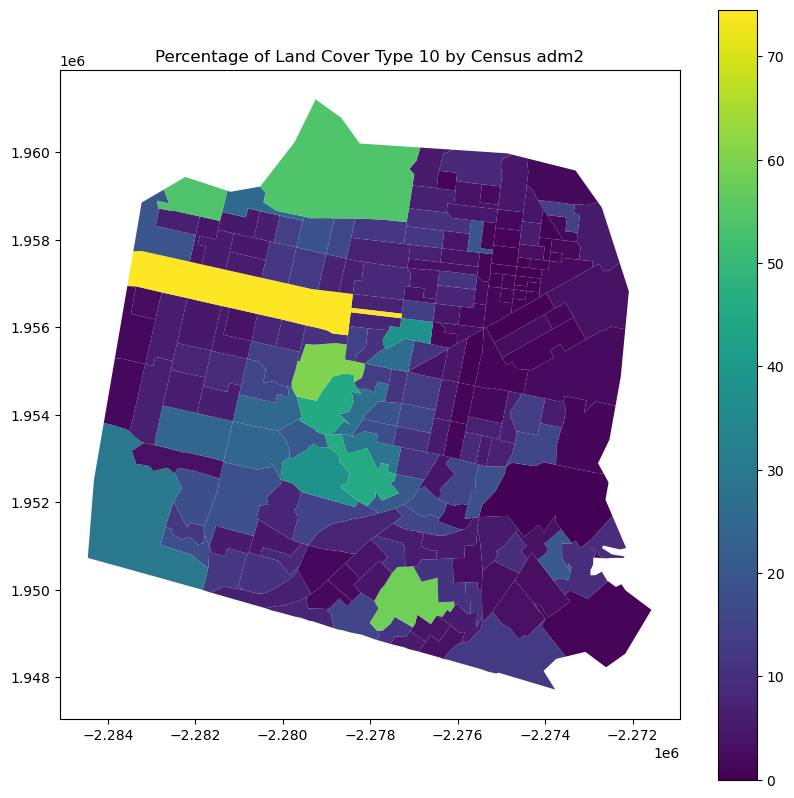

In [20]:
landcover_percent_csv = "landcover_percentages_adm"+ adm_level + ".csv"


# Compute zonal statistics (categorical) for each census tract on the clipped raster
stats = zonal_stats(aoi_admi_clipped, raster_clipped_path, categorical=True, nodata=clipped_meta["nodata"])

# Determine unique land cover classes across all tracts
unique_classes = set()
for stat in stats:
    unique_classes.update(stat.keys())
unique_classes = sorted(unique_classes)

# For each census tract, compute percentages
percent_stats = []
for stat in stats:
    total_pixels = sum(stat.values())
    tract_percent = {f"cover_{lc}": (stat.get(lc, 0) / total_pixels * 100) if total_pixels > 0 else 0 for lc in unique_classes}
    percent_stats.append(tract_percent)

# Convert to DataFrame and optionally add an identifier from census tracts (e.g., GEOID)
df_stats = pd.DataFrame(percent_stats)
print(df_stats.head())
# print(aoi_admi_clipped.head())

if "GEOID" in aoi_admi_clipped.columns:
    df_stats.insert(0, "GEOID", aoi_admi_clipped["GEOID"])

# Save the results as CSV
df_stats.to_csv(landcover_percent_csv, index=False)
print(f"CSV file saved to: {landcover_percent_csv}")

# Optionally, plot a map of the census tracts color-coded by one of the land cover percentages
# For example, you can plot the percentage of a specific land cover type, say "cover_10"
if f"cover_10" in df_stats.columns:
    aoi_admi_clipped["cover_10"] = df_stats["cover_10"]
    aoi_admi_clipped.plot(column="cover_10", cmap="viridis", legend=True, figsize=(10, 10))
    plt.title("Percentage of Land Cover Type 10 by Census adm" + adm_level)
    plt.show()


## Plot

In [21]:
import pandas as pd
import plotly.express as px

# Step 1: Load the two CSV files.
# Replace the file paths with your actual CSV file paths.
df1 = pd.read_csv(output_ndvi_csv)
df2 = pd.read_csv(landcover_percent_csv)

# Step 2: Join the two DataFrames on the 'GEOID' column.
df_joined = pd.merge(df1, df2, on="GEOID", how="inner")
print(df_joined.columns)


# If you haven't already defined a categorical variable for NDVI, you could create one.
# For instance, using the 75th percentile as a threshold:
ndvi_threshold = df_joined["weighted_ndvi"].quantile(0.75)
df_joined["NDVI_Level"] = df_joined["weighted_ndvi"].apply(
    lambda x: "Above 75th Percentile" if x > ndvi_threshold else "Below 75th Percentile"
)

# Step 3: Create a new column for marker size based on Population.
# For example, enlarge points with Population > 300.
df_joined["marker_size"] = df_joined["cover_10"].apply(lambda x: 20 if x > 30 else 5)


# Save the results as CSV
f_lc_ndvi = "landcover_ndvi_adm" + adm_level + ".csv"
df_joined.to_csv(f_lc_ndvi, index=False)
print(f"CSV file saved to: {f_lc_ndvi}")

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'AFFGEOID', 'GEOID', 'NAME', 'LSAD',
       'ALAND', 'AWATER', 'weighted_ndvi', 'cover_10', 'cover_20', 'cover_30',
       'cover_40', 'cover_50', 'cover_60', 'cover_80', 'cover_90'],
      dtype='object')
CSV file saved to: landcover_ndvi_adm2.csv


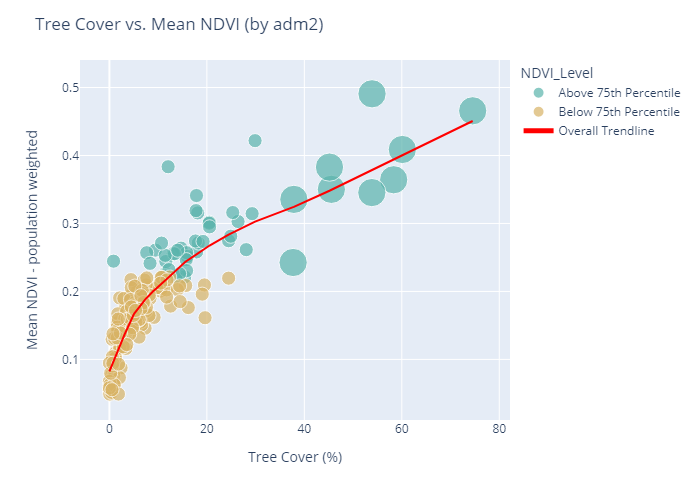

In [22]:
# import plotly.io as pio
# pio.renderers.default = "notebook"

import plotly.io as pio
pio.renderers.default = "jupyterlab+png"


# For example, assume that the joined DataFrame contains columns:
#   'GEOID', 'Population', and 'Mean_NDVI'
# We'll create a scatter plot of Mean_NDVI (y-axis) vs. Population (x-axis).

# Step 3: Create an interactive scatter plot using Plotly Express.
# - 'text' is set to 'GEOID', so each point shows the GEOID on hover.
fig = px.scatter(
    df_joined,
    x="cover_10",      # Replace with your x-axis column name
    y="weighted_ndvi", # Replace with your y-axis column name
    color="NDVI_Level",      # Color points by NDVI level category
    size="marker_size",      # Size points by marker_size

    category_orders={"NDVI_Level": ["Above 75th Percentile", "Below 75th Percentile"]}, # <-- custom order here

    # Optional: specify a custom mapping of NDVI_Level to color:
    color_discrete_map={
        "Above 75th Percentile": "#5ab4ac",
        "Below 75th Percentile": "#d8b365"
    },

    trendline="lowess",     # Adds an Ordinary Least Squares (linear) trendline
    # 'ols': Ordinary Least Squares regression line.
    # 'lowess': Locally Weighted Scatterplot Smoothing line.
    # 'rolling': Rolling average, rolling median, etc.
    trendline_color_override="red",
    trendline_scope="overall",
    # text="GEOID",      # This column will be displayed as text labels
    hover_data={"GEOID": True, "cover_10": True, "weighted_ndvi": True}
)


# Optional: update layout properties for better readability
fig.update_layout(
    title="Tree Cover vs. Mean NDVI (by adm" + adm_level + ")",
    xaxis_title="Tree Cover (%)",
    yaxis_title="Mean NDVI - population weighted",
    template="plotly" ## 'ggplot2', 'seaborn', 'simple_white', 'plotly', 'plotly_white', 'plotly_dark', 'presentation', 'none'
)

# Step 4: Display the interactive plot.
fig.show()
# fig.show("notebook") # to make the plots show up on GitHub


## Analysis

In [23]:
## use TC target to determine NDVI threshold 


import pandas as pd

# Assume df_joined is already loaded and contains the columns "Mean_NDVI" and "Population".
# For demonstration, here's an example DataFrame:
# df_joined = pd.read_csv("path/to/your_joined_data.csv")

# Define the desired percentiles
percentiles = [0.50, 0.75, 0.80, 0.85, 0.90, 0.95]

results = []  # To store summary results for each percentile

for p in percentiles:
    # Calculate the NDVI threshold at the given percentile
    threshold = df_joined["weighted_ndvi"].quantile(p)
    
    # Filter rows with NDVI values at or above the threshold
    filtered = df_joined[df_joined["weighted_ndvi"] >= threshold]
    
    # Compute the average population for those rows
    avg_population = filtered["cover_10"].mean()
    
    # Append results as a dictionary
    results.append({
        "Percentile": f"{int(p*100)}th",
        "NDVI Threshold": threshold,
        "Average cover_10": avg_population
    })

# Convert the list of dictionaries to a DataFrame
result_df = pd.DataFrame(results)

# Print the summary table
print(result_df)

# Optionally, save the summary to a CSV file:
result_df.to_csv("average_tc_by_ndvi_percentile_adm" + adm_level + ".csv", index=False)


  Percentile  NDVI Threshold  Average cover_10
0       50th        0.177417         16.049992
1       75th        0.221351         22.942715
2       80th        0.243171         24.935452
3       85th        0.258284         29.275225
4       90th        0.279257         34.622842
5       95th        0.337409         45.126239


In [24]:

# Define the TC thresholds
thresholds = [15, 20, 25, 30, 35, 40, 45, 50]

results = []

for threshold in thresholds:
    # Filter rows with Population greater than or equal to the current threshold.
    filtered = df_joined[df_joined["cover_10"] >= threshold]
    
    # Calculate the average NDVI for these rows.
    # If there are no rows meeting the criteria, set average NDVI to None.
    avg_ndvi = filtered["weighted_ndvi"].mean() if len(filtered) > 0 else None
    
    # Optionally also record the count of census tracts meeting the criteria.
    count = len(filtered)
    
    results.append({
        "TC Threshold": threshold,
        "Average NDVI": avg_ndvi,
        "Census Tracts Count": count
    })

# Convert the list of dictionaries into a DataFrame
result_df = pd.DataFrame(results)

# Print the summary table
print(result_df)

# Optionally, save the summary table to CSV
result_df.to_csv("average_ndvi_by_tc_threshold_adm" + adm_level + ".csv", index=False)


   TC Threshold  Average NDVI  Census Tracts Count
0            15      0.294254                   37
1            20      0.333773                   20
2            25      0.357344                   14
3            30      0.376239                    9
4            35      0.376239                    9
5            40      0.401166                    7
6            45      0.401166                    7
7            50      0.415009                    5


# Link NDVI to mental health outcomes

Users need to specify which mental health indicator to use, and prepare a health effect size table accordingly. 

## Select targeted effect size

In [106]:
os.getcwd()

# Define the output directory inside the parent folder
code_dir = os.path.join(parent_folder, "code")

code_path = os.path.join(code_dir, "calculate_pd_load_input.py")

# %run viz_pd.py
with open(code_path) as f:
    exec(f.read())



  health_indicator exposure_metric effect_indicator  effect_size
0       depression         0.1NDVI        odd ratio        0.931
[0.931] 
 ['odd ratio']
Selected Effect Size: 0.931
Selected Effect Size: odd ratio
Risk ratio: 0.9407366240590109


## Apply the function to the AOI

In [ ]:

code_path = os.path.join(code_dir, "calculate_pd.py")

# %run viz_pd.py
with open(code_path) as f:
    exec(f.read())


Masked NDVI raster saved: ndvi_masked.tif
Delta NE_i raster saved: delta_NE_i.tif
PD_i raster saved: PD_i.tif


## viz 1

[-3.1340410709381104, -1.5670205354690552, 0.0, 4.65069580078125, 9.3013916015625, 13.95208740234375, 18.602783203125, 23.25347900390625, 27.9041748046875]


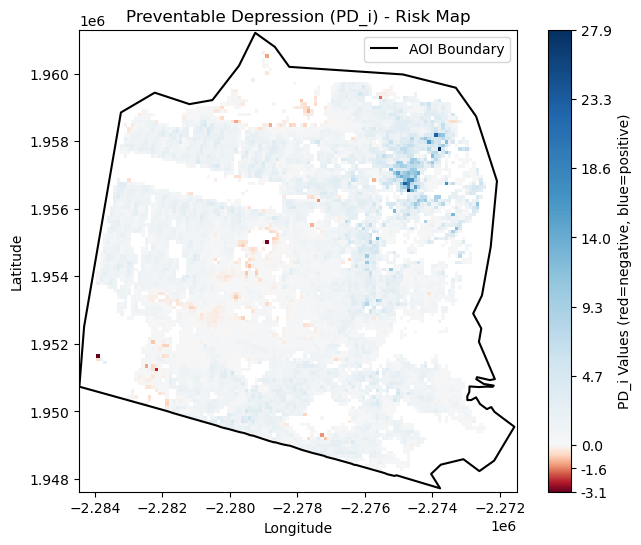

Plot saved at: D:\natcap\invest-mental-health\figures\PD_risk_map_v6.png


In [ ]:
code_path = os.path.join(code_dir, "viz_PD_1.py")

# %run viz_pd.py
with open(code_path) as f:
    exec(f.read())

## load viz 2

q: [ 0.   24.75 49.5  74.25 99.  ]
pos_ticks: [0.00000000e+00 4.30015294e-04 4.41827124e-01 9.64922901e-01
 1.70342939e+00 7.61170918e+00 7.90434046e+00]
ticks: [-0.43 -0.21  0.    0.44  0.96  1.7   7.61  7.9 ]


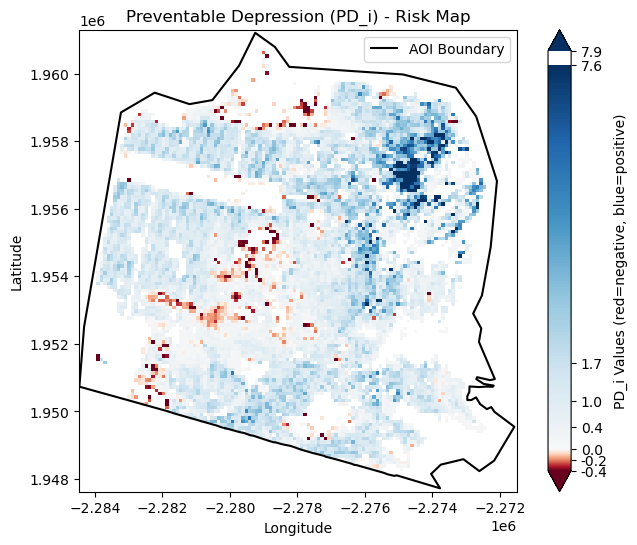

Plot saved at: D:\natcap\invest-mental-health\figures\PD_risk_map_v7.1.png


In [ ]:
code_path = os.path.join(code_dir, "viz_pd.py")
with open(code_path) as f:
    exec(f.read())


## v8

[-0.4  0.   0.3  0.9  1.1  1.5  2.7  7.6]


C:\Users\pc\AppData\Local\Temp\ipykernel_17760\3838843830.py:39: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



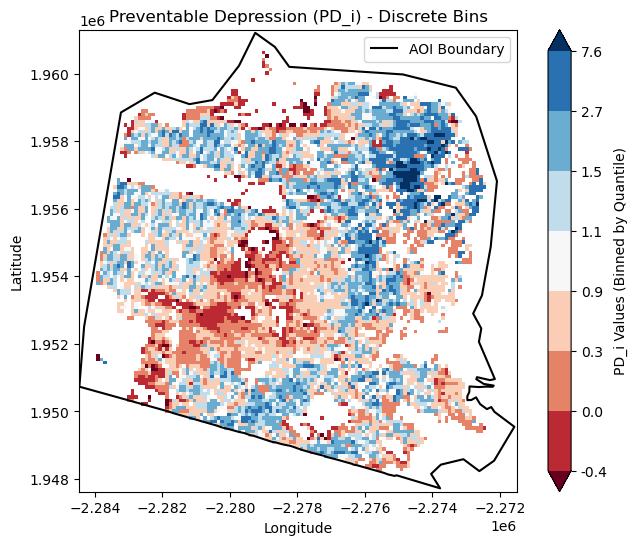

Plot saved at: D:\natcap\invest-mental-health\figures\PD_risk_map_v8_discrete.png


In [69]:
import rasterio
import rasterio.mask
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.colors as mcolors

# --- Paths and data ---
PD_raster_path = "PD_i.tif"
aoi_gdf = aoi_adm1  # Must be a valid GeoDataFrame


# Flatten and filter
PD_flat = PD_masked[0].ravel()
PD_flat = PD_flat[np.isfinite(PD_flat)]
if PD_flat.size == 0:
    raise ValueError("No valid PD_i data in the AOI. Exiting.")

# --- Compute quantile breakpoints ---
quantiles = [0.01, 0.1, 0.25, 0.50, 0.6, 0.7, 0.9, 0.99] ## remove 0 and 1 as they are way smaller or larger than other values
breakpoints = np.quantile(PD_flat, quantiles)
breakpoints = np.concatenate([breakpoints, [0]])
breakpoints = np.unique(np.round(breakpoints, 1))
print(breakpoints)

# Fallback if all breakpoints are same
if len(breakpoints) == 1:
    breakpoints = [breakpoints[0] - 1e-6, breakpoints[0] + 1e-6]

num_bins = len(breakpoints) - 1

# IMPORTANT FIX:
# 'extend="both"' demands that ncolors >= num_bins + 2
# So we set:
ncolors = num_bins + 2

# Build a discrete colormap with enough colors
cmap = plt.cm.get_cmap("RdBu", ncolors)
norm = mcolors.BoundaryNorm(breakpoints, ncolors=ncolors, extend="both")

# --- Extent for plotting ---
pd_extent = [
    PD_meta["transform"][2],
    PD_meta["transform"][2] + PD_meta["width"] * PD_meta["transform"][0],
    PD_meta["transform"][5] + PD_meta["height"] * PD_meta["transform"][4],
    PD_meta["transform"][5]
]

# --- Plot ---
fig, ax = plt.subplots(figsize=(8, 6))

im = ax.imshow(
    PD_masked[0],
    cmap=cmap,
    norm=norm,
    extent=pd_extent,
    origin="upper"
)

aoi_gdf.boundary.plot(ax=ax, edgecolor="black", linewidth=1.5, label="AOI Boundary")

# Add colorbar with 'spacing="proportional"' to reflect bins proportionally
# cbar = plt.colorbar(im, ax=ax, spacing="proportional")
cbar = plt.colorbar(im, ax=ax)
# cbar.ax.set_yscale('linear')
cbar.set_label("PD_i Values (Binned by Quantile)")

# Ticks automatically come from the boundaries
cbar.set_ticks(breakpoints)
cbar.set_ticklabels([f"{b:.1f}" for b in breakpoints])

# Title and labels
plt.title("Preventable Depression (PD_i) - Discrete Bins")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.grid(False)
ax.set_facecolor("white")
plt.legend()

output_plot_path = os.path.join(figures_dir, "PD_risk_map_v8_discrete.png")
plt.savefig(output_plot_path, dpi=300, bbox_inches="tight", transparent=True)
plt.show()

print(f"Plot saved at: {output_plot_path}")


## v9